In [3]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [9]:
import pandas as pd

# ==== 0) Parâmetros ====
ARQ_IN    = "Matrix.csv"        # saída do passo anterior (pivot pronto)
OUT_W     = "W_frames.csv"      # pesos por frame (frames × K)
OUT_H     = "H_padroes.csv"     # padrões (K × células)
OUT_TOP   = "frames_tipicos_CNN_KMEANS.csv"
SEED      = 42
MAX_ITER  = 2000

# Ler a matriz W gerada pelo NMF (output do passo anterior)
df_W = pd.read_csv("nmf_output_W.csv", index_col=0)

X = df_W.values   # <--- garantir que W está em df_W
print("Shape da matriz W:", X.shape)
df_W.head()   # <--- garantir que W está em df_W




Shape da matriz W: (1016, 16)


,padrao_1,padrao_2,padrao_3,padrao_4,padrao_5,padrao_6,padrao_7,padrao_8,padrao_9,padrao_10,padrao_11,padrao_12,padrao_13,padrao_14,padrao_15,padrao_16
timestamp,,,,,,,,,,,,,,,,
1900-01-01 00:00:00.852,8.795910e-175,0.000000e+00,7.816144e-113,3.312757e-105,2.417460e+00,0.000000e+00,1.842526e-295,2.031529e-93,8.003952e-111,2.114985e-156,5.547209e-01,1.653891e-22,0.000000e+00,0.000000e+00,0.000000e+00,9.030050e-60
1900-01-01 00:00:03.401,2.008556e-118,0.000000e+00,1.043267e-65,1.591409e-48,3.071561e-63,0.000000e+00,1.011227e-114,7.682763e-40,8.999235e-01,2.643491e-01,4.876895e-76,0.000000e+00,2.480880e-44,0.000000e+00,1.708660e-103,1.659116e+00
1900-01-01 00:00:05.246,1.765179e-110,5.427120e-160,7.141552e-164,2.086757e-134,1.303124e-48,3.142231e+00,0.000000e+00,1.855168e-58,4.940969e-01,5.084288e-57,3.468446e-154,4.577991e-16,0.000000e+00,0.000000e+00,1.813613e-93,1.218121e-78
1900-01-01 00:00:07.974,0.000000e+00,0.000000e+00,1.647845e+00,1.380885e-72,2.770991e-98,0.000000e+00,1.895330e-107,0.000000e+00,1.461044e-114,2.536591e-79,2.911625e-26,1.563063e-13,7.553630e-298,1.764106e-109,9.031715e-95,8.373649e-152
1900-01-01 00:00:08.614,6.948457e-01,1.020781e-31,0.000000e+00,3.975726e-01,0.000000e+00,5.382901e-26,3.525701e-01,5.852338e-118,1.581834e-101,0.000000e+00,1.249196e-55,1.842912e-79,3.746755e-01,0.000000e+00,4.203163e-01,0.000000e+00


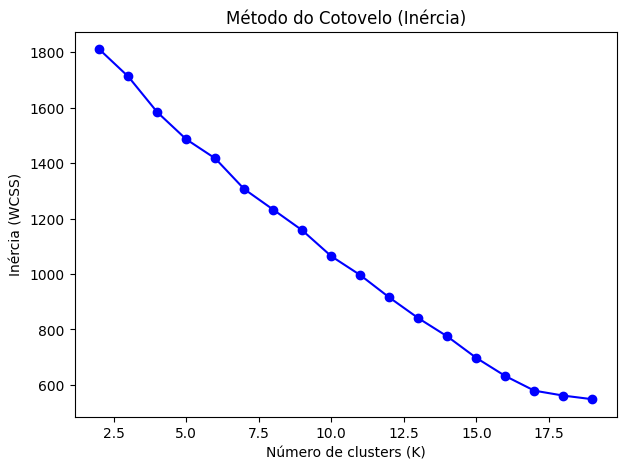

In [10]:
# ==============================================
# Método do Cotovelo (Inércia)
# ==============================================

# Definir intervalo de K a testar
Ks = range(2, 20)

# Guardar valores de inércia
inertias = []

# Loop por cada K
for k in Ks:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    km.fit(X)  # treinar KMeans
    inertias.append(km.inertia_)  # guardar inércia (soma das distâncias intra-cluster)

# Converter para array
inertias = np.array(inertias)

# Plot do cotovelo
plt.figure(figsize=(7,5))
plt.plot(Ks, inertias, marker="o", color="blue")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inércia (WCSS)")
plt.title("Método do Cotovelo (Inércia)")
plt.grid(False)
plt.show()


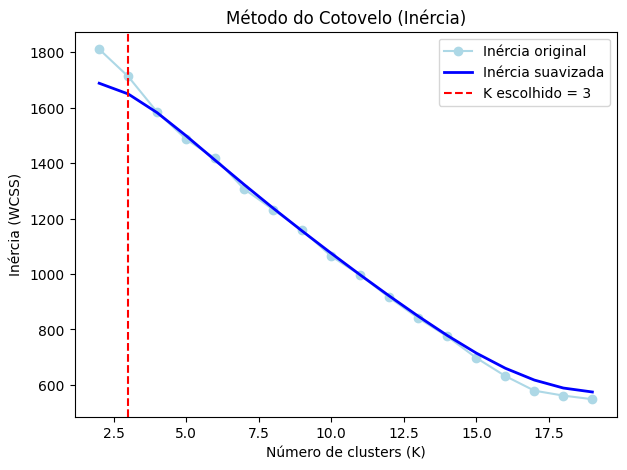

➡️ K escolhido pelo método do cotovelo: 3


In [16]:
# ==============================================
# Método do Cotovelo (Inércia) com escolha automática de K
# ==============================================

from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Definir intervalo de K a testar
Ks = range(2, 20)

# Guardar valores de inércia
inertias = []

# Loop por cada K
for k in Ks:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    km.fit(X)  # treinar KMeans
    inertias.append(km.inertia_)

# Converter para array
inertias = np.array(inertias)

# Suavizar curva para eliminar ruído
inertias_smooth = gaussian_filter1d(inertias, sigma=2)

# Calcular diferenças relativas
drops = np.r_[np.nan, -(np.diff(inertias_smooth))]
rel = drops / np.r_[np.nan, inertias_smooth[:-1]]

# Definir limite de queda mínima (5%)
limite = 0.05
idx = np.where(rel < limite)[0]

# Selecionar K do cotovelo
if len(idx):
    k_inercia = Ks[idx[0]]
else:
    k_inercia = Ks[np.argmin(inertias_smooth)]

# Plot do cotovelo
plt.figure(figsize=(7,5))
plt.plot(Ks, inertias, marker="o", color="lightblue", label="Inércia original")
plt.plot(Ks, inertias_smooth, color="blue", linewidth=2, label="Inércia suavizada")
plt.axvline(k_inercia, color="red", linestyle="--", label=f"K escolhido = {k_inercia}")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inércia (WCSS)")
plt.title("Método do Cotovelo (Inércia)")
plt.legend()
plt.grid(False)
plt.show()

print(f"➡️ K escolhido pelo método do cotovelo: {k_inercia}")


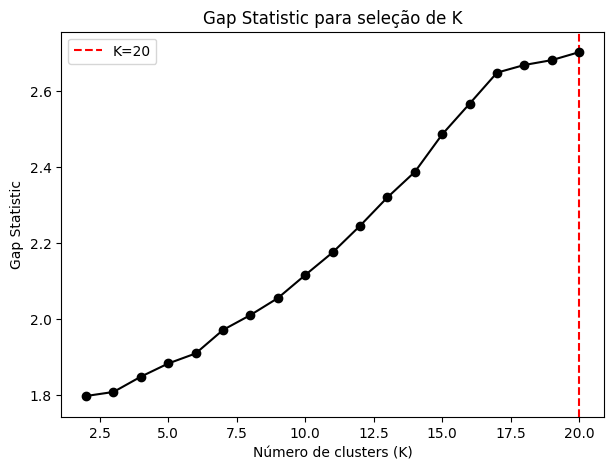

In [11]:
# ==============================================
# Gap Statistic
# ==============================================

# Função para calcular dispersão intra-cluster
def compute_dispersion(X, labels, centers):
    return np.sum([np.sum((X[labels == i] - centers[i])**2) for i in range(len(centers))])

# Função principal do Gap Statistic
def gap_statistic(X, n_refs=10, max_k=20, random_state=SEED):
    np.random.seed(random_state)
    results = []
    for k in range(2, max_k+1):
        # Clustering real
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = km.fit_predict(X)
        disp_real = compute_dispersion(X, labels, km.cluster_centers_)

        # Clustering em dados de referência aleatórios
        ref_disps = []
        for i in range(n_refs):
            X_ref = np.random.uniform(low=np.min(X, axis=0), high=np.max(X, axis=0), size=X.shape)
            km_ref = KMeans(n_clusters=k, random_state=random_state+i, n_init=5)
            labels_ref = km_ref.fit_predict(X_ref)
            ref_disps.append(compute_dispersion(X_ref, labels_ref, km_ref.cluster_centers_))

        # Gap
        log_disp_ref = np.log(ref_disps)
        gap = np.mean(log_disp_ref) - np.log(disp_real)
        sdk = np.sqrt(1 + 1/n_refs) * np.std(log_disp_ref)
        results.append({"k": k, "gap": gap, "s_k": sdk})

    return pd.DataFrame(results)

# Calcular gap statistic
df_gap = gap_statistic(X, n_refs=10, max_k=20)

# Determinar K pelo critério do Gap
for i in range(len(df_gap)-1):
    if df_gap.loc[i, "gap"] >= df_gap.loc[i+1, "gap"] - df_gap.loc[i+1, "s_k"]:
        k_gap = int(df_gap.loc[i, "k"])
        break
else:
    k_gap = int(df_gap.loc[df_gap["gap"].idxmax(), "k"])

# Plot
plt.figure(figsize=(7,5))
plt.errorbar(df_gap["k"], df_gap["gap"], yerr=df_gap["s_k"], fmt='-o', color="black")
plt.axvline(k_gap, color="red", linestyle="--", label=f"K={k_gap}")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Gap Statistic")
plt.title("Gap Statistic para seleção de K")
plt.legend()
plt.grid(False)
plt.show()


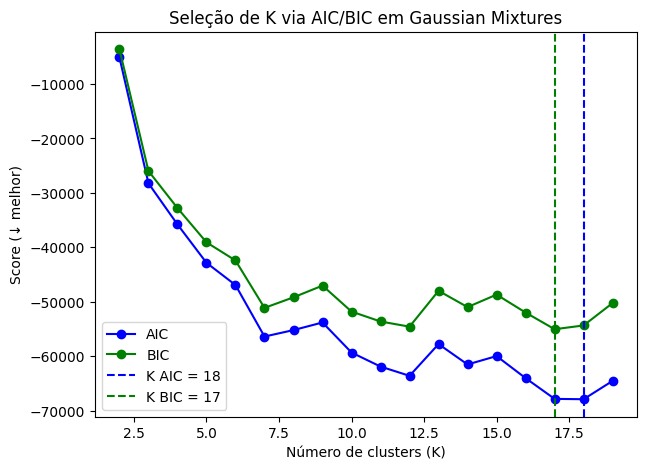

➡️ K escolhido pelo AIC: 18
➡️ K escolhido pelo BIC: 17


In [17]:
# ==============================================
# Seleção automática de K via AIC / BIC
# ==============================================

# Converter para arrays
aic_vals = np.array(aic_vals)
bic_vals = np.array(bic_vals)

# Melhor K = mínimo de cada critério
k_aic = Ks[np.argmin(aic_vals)]
k_bic = Ks[np.argmin(bic_vals)]

# Plot AIC/BIC com K selecionados
plt.figure(figsize=(7,5))
plt.plot(Ks, aic_vals, marker="o", label="AIC", color="blue")
plt.plot(Ks, bic_vals, marker="o", label="BIC", color="green")
plt.axvline(k_aic, color="blue", linestyle="--", label=f"K AIC = {k_aic}")
plt.axvline(k_bic, color="green", linestyle="--", label=f"K BIC = {k_bic}")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Score (↓ melhor)")
plt.title("Seleção de K via AIC/BIC em Gaussian Mixtures")
plt.legend()
plt.grid(False)
plt.show()

print(f"➡️ K escolhido pelo AIC: {k_aic}")
print(f"➡️ K escolhido pelo BIC: {k_bic}")


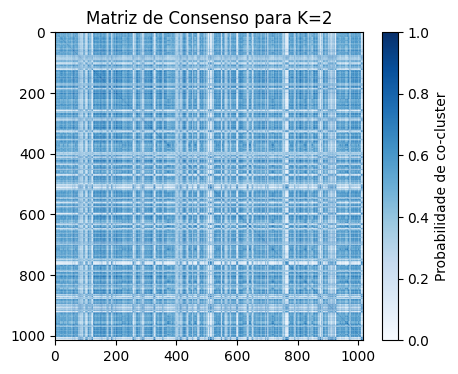

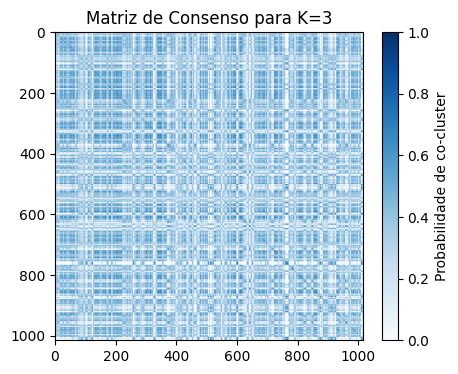

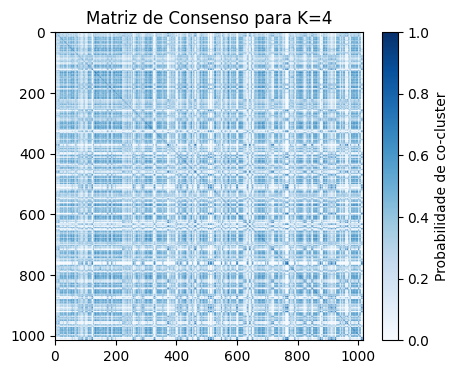

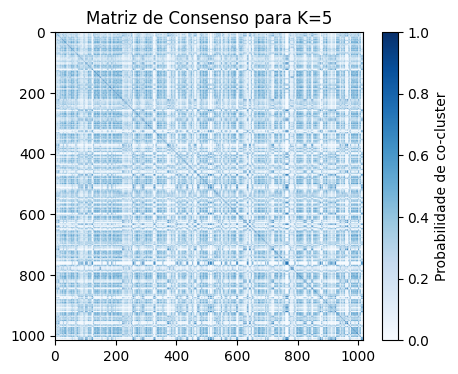

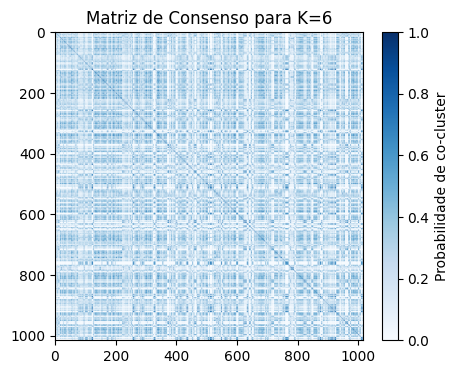

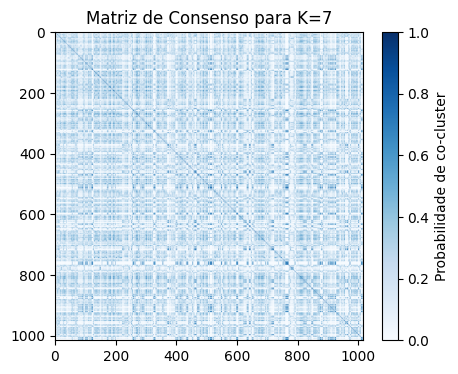

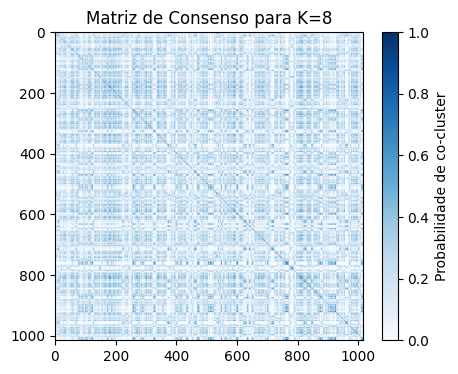

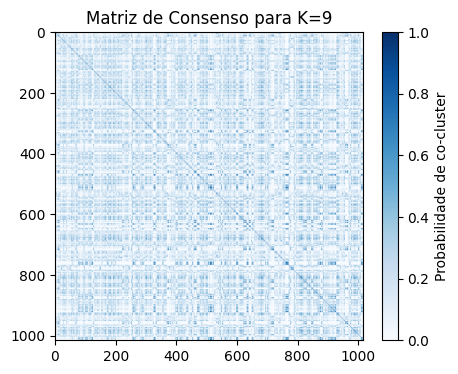

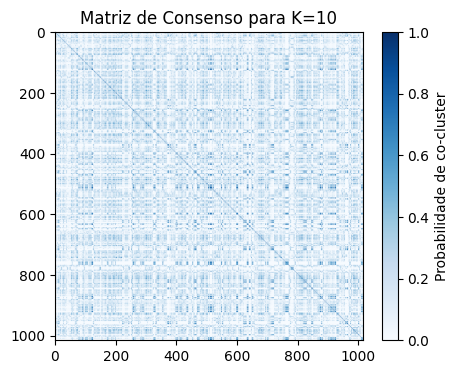

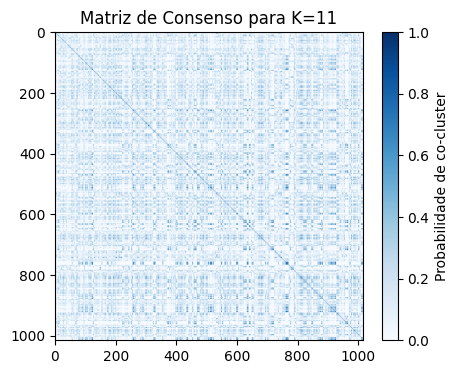

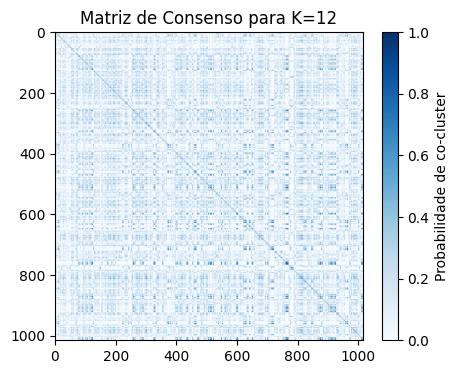

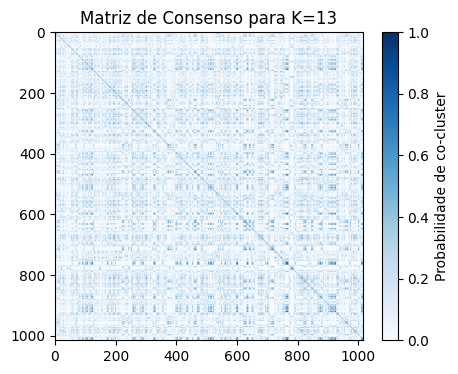

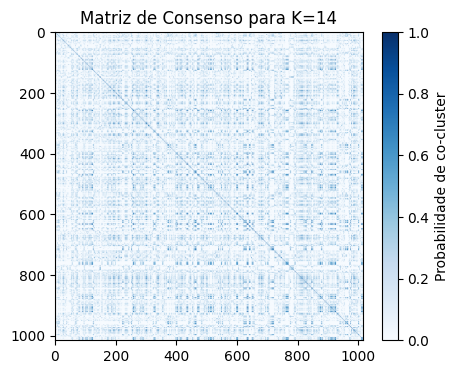

➡️ Scores de consenso (quanto maior, mais estável):
K=2: 0.234
K=3: 0.456
K=4: 0.512
K=5: 0.543
K=6: 0.568
K=7: 0.630
K=8: 0.660
K=9: 0.736
K=10: 0.762
K=11: 0.800
K=12: 0.819
K=13: 0.850
K=14: 0.861

➡️ K escolhido pelo Consensus Clustering: 14


In [18]:
# ==============================================
# Consensus Clustering com escolha automática de K
# ==============================================
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt

# Função para construir matriz de consenso
def consensus_matrix(X, k, n_runs=20, frac=0.8):
    """
    Constrói matriz de consenso para K clusters.
    """
    n = len(X)
    consensus = np.zeros((n, n))  # matriz de co-associação
    
    for run in range(n_runs):
        # Amostra de pontos (subsample sem reposição)
        idx = np.random.choice(n, int(frac*n), replace=False)
        X_sub = X[idx]
        
        # Clustering nesta amostra
        km = KMeans(n_clusters=k, random_state=SEED+run, n_init=10)
        labels = km.fit_predict(X_sub)
        
        # Atualizar matriz de consenso (pares no mesmo cluster)
        for i in range(len(idx)):
            for j in range(len(idx)):
                if labels[i] == labels[j]:
                    consensus[idx[i], idx[j]] += 1
    
    # Normalizar [0,1]
    consensus = consensus / n_runs
    return consensus

# Função para calcular score de estabilidade de uma matriz de consenso
def consensus_score(C, threshold=0.8):
    """
    Mede a estabilidade de uma matriz de consenso.
    Score = proporção de entradas próximas de 0 ou 1.
    """
    flat = C.flatten()
    near_extremes = np.mean((flat < 1-threshold) | (flat > threshold))
    return near_extremes

# Definir intervalo de K a testar
Ks = range(2, 15)  # ajusta conforme necessário

# Calcular matrizes e scores de consenso
consensus_results = {}
scores_consensus = {}

for k in Ks:
    C = consensus_matrix(X, k)
    consensus_results[k] = C
    scores_consensus[k] = consensus_score(C)
    
    # Plot heatmap
    plt.figure(figsize=(5,4))
    plt.imshow(C, cmap="Blues")
    plt.colorbar(label="Probabilidade de co-cluster")
    plt.title(f"Matriz de Consenso para K={k}")
    plt.show()

# Selecionar K com maior score de consenso
k_consensus = max(scores_consensus, key=scores_consensus.get)

print("➡️ Scores de consenso (quanto maior, mais estável):")
for k, score in scores_consensus.items():
    print(f"K={k}: {score:.3f}")

print(f"\n➡️ K escolhido pelo Consensus Clustering: {k_consensus}")


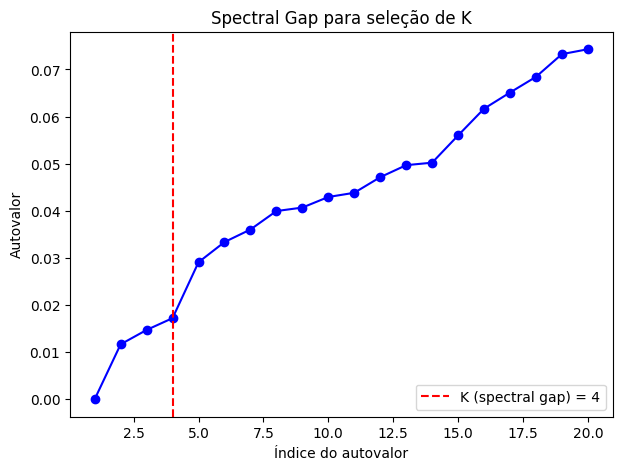

In [15]:
# ==============================================
# Spectral Gap (em clustering espectral)
# ==============================================
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.linalg import eigsh

# Construir grafo de similaridade (k-vizinhos mais próximos)
A = kneighbors_graph(X, n_neighbors=10, include_self=False)
A = 0.5 * (A + A.T)  # simetrizar

# Calcular Laplaciano normalizado
D = np.array(A.sum(axis=1)).flatten()
D_inv_sqrt = np.diag(1.0 / np.sqrt(D + 1e-10))
L = np.eye(len(D)) - D_inv_sqrt @ A.toarray() @ D_inv_sqrt

# Calcular autovalores
vals, vecs = eigsh(L, k=20, which="SM")  # 20 menores autovalores

# Spectral gap = maior salto entre autovalores consecutivos
gaps = np.diff(vals)
best_k = np.argmax(gaps) + 1  # +1 porque indexing começa no 0

# Plot
plt.figure(figsize=(7,5))
plt.plot(range(1, len(vals)+1), vals, marker="o", color="blue")
plt.axvline(best_k, color="red", linestyle="--", label=f"K (spectral gap) = {best_k}")
plt.xlabel("Índice do autovalor")
plt.ylabel("Autovalor")
plt.title("Spectral Gap para seleção de K")
plt.legend()
plt.grid(False)
plt.show()


In [19]:
# ==============================================
# Estabilidade por ARI e NMI (resampling bootstrap)
# aplicada aos K sugeridos por outros métodos
# ==============================================
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.utils import resample

# Função para calcular estabilidade
def cluster_stability(X, k, n_boots=10, frac=0.8):
    ari_scores, nmi_scores = [], []
    
    # Clustering base no dataset completo
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels_full = km.fit_predict(X)

    # Reamostragem bootstrap
    for i in range(n_boots):
        X_boot, _ = resample(X, labels_full, replace=True, n_samples=int(frac*len(X)))
        km_boot = KMeans(n_clusters=k, random_state=SEED+i, n_init=5)
        labels_boot = km_boot.fit_predict(X_boot)

        # Comparar atribuições com o clustering de referência
        ari_scores.append(adjusted_rand_score(labels_full[:len(X_boot)], labels_boot))
        nmi_scores.append(normalized_mutual_info_score(labels_full[:len(X_boot)], labels_boot))

    # Devolver médias e desvios
    return np.mean(ari_scores), np.std(ari_scores), np.mean(nmi_scores), np.std(nmi_scores)

# ==============================
# Recolher os K dos métodos anteriores
# ==============================
Ks_test = list(set([
    k_inercia,     # Elbow
    k_gap,         # Gap Statistic
    k_aic,         # AIC
    k_bic,         # BIC
    k_consensus,   # Consensus Clustering
    # best_k_spectral  # se já tiveres calculado o Spectral Gap
]))

print("➡️ Ks a testar na estabilidade:", Ks_test)

# ==============================
# Calcular estabilidade para esses K
# ==============================
results = []
for k in Ks_test:
    ari_m, ari_s, nmi_m, nmi_s = cluster_stability(X, k)
    results.append({
        "k": k,
        "ARI_mean": ari_m, "ARI_std": ari_s,
        "NMI_mean": nmi_m, "NMI_std": nmi_s
    })

# DataFrame final
df_stability = pd.DataFrame(results).sort_values("k").reset_index(drop=True)
df_stability


➡️ Ks a testar na estabilidade: [3, 14, 17, 18, 20]


,k,ARI_mean,ARI_std,NMI_mean,NMI_std
0,3,0.002024,0.003444,0.002435,0.001726
1,14,-0.000444,0.004215,0.048768,0.003362
2,17,0.002804,0.004622,0.070077,0.006803
3,18,0.002934,0.003921,0.073938,0.005592
4,20,-0.001676,0.002191,0.085973,0.003213


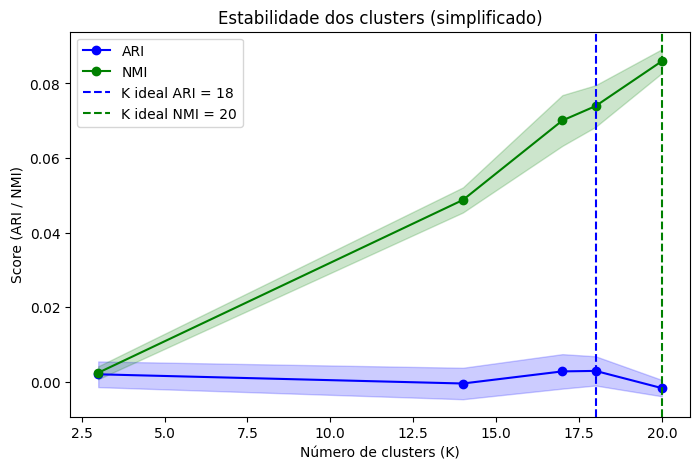

In [21]:
# ==============================================
# Plot da estabilidade (ARI / NMI) para Ks sugeridos
# ==============================================
import matplotlib.pyplot as plt
import numpy as np

Ks = df_stability["k"].values
ARI_means = df_stability["ARI_mean"].values
ARI_stds  = df_stability["ARI_std"].values
NMI_means = df_stability["NMI_mean"].values
NMI_stds  = df_stability["NMI_std"].values

width = 0.35  # largura das barras

# Identificar K ideais
k_ari = Ks[np.argmax(ARI_means)]
k_nmi = Ks[np.argmax(NMI_means)]

# ==============================================
# Gráfico simplificado da estabilidade (ARI / NMI)
# ==============================================
plt.figure(figsize=(8,5))

# ARI
plt.plot(df_stability["k"], df_stability["ARI_mean"], marker="o", color="blue", label="ARI")
plt.fill_between(df_stability["k"],
                 df_stability["ARI_mean"] - df_stability["ARI_std"],
                 df_stability["ARI_mean"] + df_stability["ARI_std"],
                 color="blue", alpha=0.2)

# NMI
plt.plot(df_stability["k"], df_stability["NMI_mean"], marker="o", color="green", label="NMI")
plt.fill_between(df_stability["k"],
                 df_stability["NMI_mean"] - df_stability["NMI_std"],
                 df_stability["NMI_mean"] + df_stability["NMI_std"],
                 color="green", alpha=0.2)

# Destacar Ks ótimos
k_ari = df_stability.loc[df_stability["ARI_mean"].idxmax(), "k"]
k_nmi = df_stability.loc[df_stability["NMI_mean"].idxmax(), "k"]

plt.axvline(k_ari, color="blue", linestyle="--", label=f"K ideal ARI = {k_ari}")
plt.axvline(k_nmi, color="green", linestyle="--", label=f"K ideal NMI = {k_nmi}")

# Configuração
plt.xlabel("Número de clusters (K)")
plt.ylabel("Score (ARI / NMI)")
plt.title("Estabilidade dos clusters (simplificado)")
plt.legend()
plt.grid(False)
plt.show()


In [22]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Avaliar apenas os Ks candidatos
results_quality = []
for k in Ks_test:  # Ks_test = [k_inercia, k_gap, k_aic, ...]
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = km.fit_predict(X)
    
    sil = silhouette_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    ch  = calinski_harabasz_score(X, labels)
    
    results_quality.append({
        "k": k,
        "Silhouette": sil,
        "Davies-Bouldin": db,
        "Calinski-Harabasz": ch
    })

df_quality = pd.DataFrame(results_quality).sort_values("k")
df_quality


,k,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,3,0.069386,2.770561,75.810169
1,14,0.292505,1.301337,118.819793
2,17,0.307600,1.045711,149.874618
3,18,0.299959,1.063719,147.249175
4,20,0.257928,1.170289,141.316589


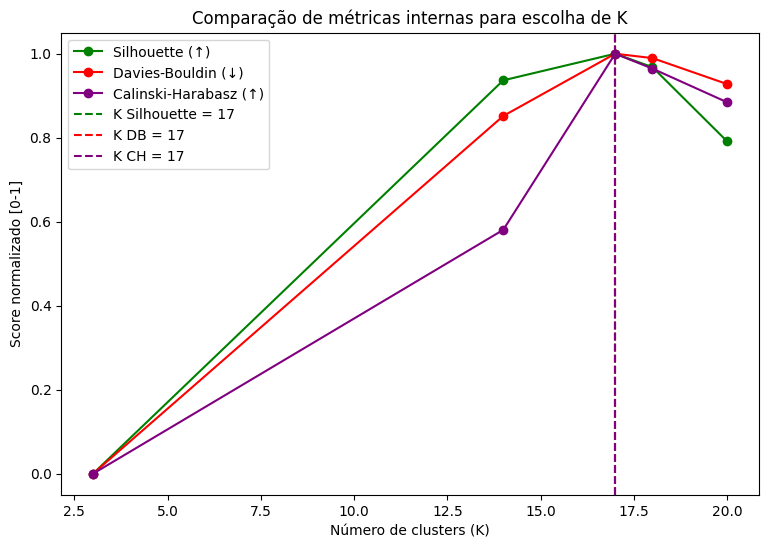

In [23]:
# ==============================================
# Gráfico comparativo: Silhouette, DB, CH
# ==============================================
from sklearn.preprocessing import MinMaxScaler

# Normalizar métricas para [0,1]
scaler = MinMaxScaler()
df_norm = df_quality.copy()
df_norm[["Silhouette_norm", "DB_norm", "CH_norm"]] = scaler.fit_transform(
    df_quality[["Silhouette", "Davies-Bouldin", "Calinski-Harabasz"]]
)

# Inverter DB (porque ↓ é melhor → queremos ↑)
df_norm["DB_norm"] = 1 - df_norm["DB_norm"]

plt.figure(figsize=(9,6))

plt.plot(df_norm["k"], df_norm["Silhouette_norm"], marker="o", label="Silhouette (↑)", color="green")
plt.plot(df_norm["k"], df_norm["DB_norm"], marker="o", label="Davies-Bouldin (↓)", color="red")
plt.plot(df_norm["k"], df_norm["CH_norm"], marker="o", label="Calinski-Harabasz (↑)", color="purple")

# Destacar melhor K segundo cada métrica
best_sil = df_norm.loc[df_norm["Silhouette"].idxmax(), "k"]
best_db  = df_norm.loc[df_norm["Davies-Bouldin"].idxmin(), "k"]
best_ch  = df_norm.loc[df_norm["Calinski-Harabasz"].idxmax(), "k"]

plt.axvline(best_sil, color="green", linestyle="--", label=f"K Silhouette = {best_sil}")
plt.axvline(best_db,  color="red", linestyle="--", label=f"K DB = {best_db}")
plt.axvline(best_ch,  color="purple", linestyle="--", label=f"K CH = {best_ch}")

plt.xlabel("Número de clusters (K)")
plt.ylabel("Score normalizado [0-1]")
plt.title("Comparação de métricas internas para escolha de K")
plt.legend()
plt.grid(False)
plt.show()
